In [22]:
import numpy as np
from copy import copy

# Déneigeuse - Etude de la Théorie

### Introduction

Dans ce notebook nous allons expliquer le fonctionnement de notre algorithme sur un exemple d'un petit graphe. Ce graphe est orienté et peut représenter un quartier de Montréal. Notre graphe est connexe mais peut quand même avoir des impasses. Les arêtes du graphe peuvent être vues comme des routes, elles sont soit à sens unique soit à double sens.

### Exlication de l'algorithme

La première méthode qui nous est venu à l'esprit était de chercher le chemin eulérien. Notre graphe étant orienté et n'étant pas forcément semi-eulérien, la recherche du chemin eulérien nécessite quelques modifications. Notre méthode pour trouver le chemin le plus optimal est donc la suivante :

1. Transformer notre graphe en un graphe semi-eulérien en ajoutant des arêtes.

2. Rechercher un chemin sur le nouveau graphe semi-eulérien.

3. Transposer le chemin trouvé sur le graphe initial.

4. Remplacer les passages du chemin eulérien qui n'existent pas par les chemins les plus courts en prenant en compte les sens des arêtes. Si on n'arrive pas trouver le chemin le plus court, on refait une recherche en considérant le graphe comme étant non orienté.

### Trouver le chemin le plus court entre deux noeuds 

Pour trouver le chemin le plus court nous allons utiliser l'algorithme de Dijkstra. Nous avons implémenté une fonction qui adaptée aux graphes orientés et non orientés, il suffit juste de préciser le type en paramètre. Notre fonction renvoie un tuple ([chemin], distance). Dans le cas où le chemin n'existe pas, la fonction renvoie (None, 0). L'algorithme est le suivant:

1. Marquer tous les sommets non visités. Créer un ensemble de tous les sommets non visités.

2. Attribuer une valeur de distance nulle au sommet source et une valeur de distance infinie à tous les autres sommets.

3. Définir le sommet source comme sommet actuel.

4. Pour le sommet actuel, considérer tous ses voisins non visités et calculer leurs distances provisoires à travers le courant. (distance actuelle + poids de l'arête correspondante) 

5. Comparer la distance nouvellement calculée à la valeur assignée actuelle (peut être l'infini pour certains sommets) et attribuez la plus petite.

6. Après avoir considéré tous les voisins non visités du sommet actuel, marquer le courant comme visité et le supprimer de l'ensemble non visité.

7. De même, continuer pour tous les sommets jusqu'à ce que tous les nœuds soient visités.

In [24]:
def dijkstra(G, start, end, is_directed):
    # conversions
    graph = {}
    # calculate total number of vertices
    total = 0
    for (a, b, w) in G:
        if a > total:
            total = a
        if b > total:
            total = b
    for i in range(total + 1):
        graph[i] = {}
    for (a, b, w) in G:
        graph[a][b] = w
        if not is_directed: # if the graph is not directed add the same edge but in reverse direction
            graph[b][a] = w
    
    # empty dictionary to hold distances
    distances = {} 
    # list of vertices in path to current vertex
    predecessors = {} 
    
    # get all the vertices that need to be assessed
    to_assess = graph.keys() 

    # set all initial distances to infinity
    #  and no predecessor for any node
    for node in graph:
        distances[node] = float('inf')
        predecessors[node] = None
    
    # set the initial collection of 
    # permanently labelled nodes to be empty
    sp_set = []

    # set the distance from the start vertex to be 0
    distances[start] = 0
    
    # as long as there are still vertices to assess:
    while len(sp_set) < len(to_assess):

        # chop out any vertices with a permanent label
        still_in = {node: distances[node]\
                    for node in [node for node in\
                    to_assess if node not in sp_set]}

        # find the closest node to the current vertex
        closest = min(still_in, key = distances.get)

        # and add it to the permanently labelled vertices
        sp_set.append(closest)
        
        # then for all the neighbours of 
        # the closest vertex (that was just added to
        # the permanent set)
        for node in graph[closest]:
            # if a shorter path to that node can be found
            if distances[node] > distances[closest] +\
                       graph[closest][node]:

                # update the distance with 
                # that shorter distance
                distances[node] = distances[closest] +\
                       graph[closest][node]

                # set the predecessor for that node
                predecessors[node] = closest
                
    # once the loop is complete the final 
    # path needs to be calculated - this can
    # be done by backtracking through the predecessors
    path = [end]
    while start not in path:
        if (predecessors[path[-1]] == None): # it means that path doesnt exist
            return None, 0
        path.append(predecessors[path[-1]])
    
    # return the path in order start -> end, and it's cost
    return path[::-1], distances[end]

# Example of dict :
# graph = {
#        '1': {'2': 1, '4':  1},
#        '2': {'1': 1, '4':  1, '3':  2},
#        '3': {'2':2, '4':1, '5':1, '6':1},
#        '4': {'1':  1, '2':  1, '3':1, '5':2, '6':15},
#        '5': {'3': 1, '4':2, '6':1},
#        '6': {'3': 1, '4':15, '5':1}
#     }

### Transformer un graphe orienté en un graphe orienté semi-eulerien

Pour transformer notre graphe nous allons ajouter des aretes en nous basant sur la caractéristique suivante: "Le graphe est semi-eulérien s'il a au maximum un sommet avec demi_degré_intérieur = demi_degré_extérieur + 1 et au maximum un sommet avec demi_degré_extérieur = demi_degré_intérieur + 1, tous les autres noeuds doivent avoir leur demi_degré_intérieur == demi_degré_extérieur".

Notre fonction commence par séparer les noeuds du graphe en 5 groupes en fonctions de leurs degrés:
- demi_degré_intérieur == demi_degré_extérieur 
- demi_degré_intérieur + 1 == demi_degré_extérieur
- demi_degré_intérieur == demi_degré_extérieur + 1
- demi_degré_intérieur + 1 < demi_degré_extérieur
- demi_degré_intérieur > demi_degré_extérieur + 1

Ensuite on relie ces noeuds pour que le graphe puisse répondre à la propriété citée ci-dessus. Lors de la création de la nouvelle arête sa distance est calculée avec l'algorithme de Dijkstra, ainsi on garantit que la déneigeuse parcourt la bonne distance.

In [1]:
# Function converting directed graph to directed eulerian graph
def directed_to_eulerian(G):
    # create a copy of G to not modify the initial graph
    G_copy = copy(G)
    # create lists of vertices with their in and out degrees (vertice_number, inv, outv)
    in_bigger = [] # in = out + 1
    out_bigger = [] # out = in + 1
    in_dominant = [] # in > out + 1
    out_dominant = [] # out > in + 1
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    for i in range(m + 1): # for each vertice of the graph count the number of in and out
        inv = 0
        outv = 0
        for (a, b, w) in G:
            if (i == a):
                outv += 1
            if (i == b):
                inv += 1
        # adding all vertices in their respective list        
        if (inv == outv + 1):
            in_bigger.append((i, inv, outv))
        elif (outv == inv + 1):
            out_bigger.append((i, inv, outv))
        elif (inv > outv + 1):
            in_dominant.append((i, inv, outv))
        elif (inv != outv):
            out_dominant.append((i, inv, outv))
    
    while (len(out_bigger) > 1 or len(in_bigger) > 1) or len(in_dominant) > 0 or len(out_dominant) > 0:
        while (len(in_bigger) > 1):
            (i, inv, outv) = in_bigger[0]
            if (len(out_dominant) > 0):
                (i2, inv2, outv2) = out_dominant[0]
                # find the shortest distance using dijkstra to create new edge
                path, dist = dijkstra(G, i, i2, is_directed=False)
                # adding edge 1 -> 2
                G_copy.append((i, i2, dist))
                # removing first vertice from the list because it now has equla number of in and out
                in_bigger.pop(0)
                if (inv2 + 1 == outv2):
                    out_dominant.pop(0) # if new inv == outv remove
                elif (inv2 + 2 == outv2):
                    out_dominant.pop(0)
                    out_bigger.append(((i2, inv2 + 1, outv2))) # if 'out dominant' node becames 'out bigger' node
                else:
                    out_dominant[0] = (i2, inv2 + 1, outv2) # if its not equal just update new inv
            elif (len(out_bigger) > 0):
                (i2, inv2, outv2) = out_bigger[0]
                # adding edge 1 -> 2
                # find the shortest distance using dijkstra to create new edge
                path, dist = dijkstra(G, i, i2, is_directed=False)
                G_copy.append((i, i2, dist))
                in_bigger.pop(0)
                out_bigger.pop(0)
            else:
                print("1 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(out_bigger) > 1):
            (i, inv, outv) = out_bigger[0]
            if (len(in_dominant) > 0):
                (i2, inv2, outv2) = in_dominant[0]
                # find the shortest distance using dijkstra to create new edge
                path, dist = dijkstra(G, i2, i, is_directed=False)
                G_copy.append((i2, i, dist))
                out_bigger.pop(0)
                if (outv2 + 1 == inv2):
                    in_dominant.pop(0)
                elif (outv2 + 2 == inv2):
                    in_dominant.pop(0)
                    in_bigger.append(((i2, inv2, outv2 + 1))) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i2, inv2, outv2 + 1)
            elif (len(in_bigger) > 0):
                (i2, inv2, outv2) = in_bigger[0]
                # find the shortest distance using dijkstra to create new edge
                path, dist = dijkstra(G, i2, i, is_directed=False)
                G_copy.append((i2, i, dist))
                out_bigger.pop(0)
                in_bigger.pop(0)
            else:
                print("2 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(in_dominant) > 0):
            (i, inv, outv) = in_dominant[0]
            if (len(out_dominant) > 0):
                (i2, inv2, outv2) = out_dominant[0]
                # find the shortest distance using dijkstra to create new edge
                path, dist = dijkstra(G, i, i2, is_directed=False)
                G_copy.append((i, i2, dist))
                if (outv + 1 == inv):
                    in_dominant.pop(0)
                elif (outv + 2 == inv):
                    in_dominant.pop(0)
                    in_bigger.append((i, inv, outv + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i, inv, outv + 1)
                # do the same for out_dominant
                if (inv2 + 1 == outv2):
                    out_dominant.pop(0)
                elif (inv2 + 2 == outv2):
                    out_dominant.pop(0)
                    out_bigger.append((i2, inv2 + 1, outv2)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i2, inv2 + 1, outv2)
            elif (len(out_bigger) > 0):
                (i2, inv2, outv2) = out_bigger[0]
                # find the shortest distance using dijkstra to create new edge
                path, dist = dijkstra(G, i, i2, is_directed=False)
                G_copy.append((i, i2, dist))
                out_bigger.pop(0)
                if (outv + 1 == inv):
                    in_dominant.pop(0)
                elif (outv + 2 == inv):
                    in_dominant.pop(0)
                    in_bigger.append((i, inv, outv + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i, inv, outv + 1)
            
            else:
                print("3 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(out_dominant) > 0):
            (i, inv, outv) = out_dominant[0]
            if (len(in_dominant) > 0):
                (i2, inv2, outv2) = in_dominant[0]
                # find the shortest distance using dijkstra to create new edge
                path, dist = dijkstra(G, i, i2, is_directed=False)
                G_copy.append((i, i2, dist))
                if (inv + 1 == outv):
                    out_dominant.pop(0)
                elif (inv + 2 == outv):
                    out_dominant.pop(0)
                    out_bigger.append((i, inv + 1, outv)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i, inv + 1, outv)
                # do the same for in_dominant
                if (outv2 + 1 == inv2):
                    in_dominant.pop(0)
                elif (outv2 + 2 == inv2):
                    in_dominant.pop(0)
                    in_bigger.append((i2, inv2, outv2 + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i2, inv2, outv2 + 1)
            elif (len(in_bigger) > 0):
                (i2, inv2, outv2) = in_bigger[0]
                # find the shortest distance using dijkstra to create new edge
                path, dist = dijkstra(G, i2, i, is_directed=False)
                G_copy.append((i2, i, dist))
                in_bigger.pop(0)
                if (inv + 1 == outv):
                    out_dominant.pop(0)
                elif (inv + 2 == outv):
                    out_dominant.pop(0)
                    out_bigger.append((i, inv + 1, outv)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i, inv + 1, outv)
            
            else:
                print("4 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
                
    return G_copy        

### Trouver un chemin eulerien sur un graphe orienté

Pour trouver le chemin eulerien nous allons utiliser une version un peu modifiée de l'algorithme de Hierholzer. Dans la version classique cet algorithme permet de rechercher non pas le chemin mais le circuit eulerien. Pour trouver le chemin il suffit jsute de bien définir le noeud de départ. Et la condition pour le noeud de départ est que son demi-degre degré extérieur soit supérieur à son demi-degré intérieur.

In [7]:
# Hierholzer’s Algorithm for directed graph

# function converting our graph to an adj list
def graph_to_adj(G):
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    adj = [[] for _ in range(m + 1)]
    
    for (a, b, w) in G:
        adj[a].append(b)
    return adj
    
def get_eulerian_path(G):
    adj = graph_to_adj(G)
    # adj represents the adjacency list of
    # the directed graph
    # edge_count represents the number of edges
    # emerging from a vertex
        
    edge_count = dict()
  
    for i in range(len(adj)):
  
        # find the count of edges to keep track
        # of unused edges
        edge_count[i] = len(adj[i])
  
    if len(adj) == 0:
        return # empty graph
  
    # Maintain a stack to keep vertices
    curr_path = []
  
    # vector to store final circuit
    circuit = []
  
    # find the start vertex (indeg + 1 = outdeg)
    # create lists of vertices with their in and out (vertice_number, inv, outv)
    start_vertex = (0, 0, 0) # out = in + 1
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    for i in range(m + 1): # for each vertice of the graph count the number of in and out
        inv = 0
        outv = 0
        for (a, b, w) in G:
            if (i == a):
                outv += 1
            if (i == b):
                inv += 1
        # adding all vertices in their respective list 
        if (outv == inv + 1):
            start_vertex = (i, inv, outv)
    
    # find the end vertex (outdeg + 1 = indeg) if there is no end vertex
    
    
    # start from the start_vertex, if there is no start vertex, start from 0
    curr_path.append(start_vertex[0])
    curr_v = start_vertex[0] # Current vertex
  
    while len(curr_path): # while stack isn't empty
  
        # If there's remaining edge
        if edge_count[curr_v]: # while in edge_count list there is still some edges 
  
            # Push the vertex
            curr_path.append(curr_v)
  
            # Find the next vertex using an edge
            next_v = adj[curr_v][-1]
  
            # and remove that edge
            edge_count[curr_v] -= 1
            adj[curr_v].pop()
  
            # Move to next vertex
            curr_v = next_v
  
        # back-track to find remaining path
        else:
            circuit.append(curr_v)
  
            # Back-tracking
            curr_v = curr_path[-1]
            curr_path.pop()
  
    # we've got the path, now return its reverse
    rev = []
    for item in circuit[::-1]:
        rev.append(item)
    return rev

### Remplacer les routes qui n'existent pas

On remplace les arrêtes qui ne devraient pas exister par le chemin le plus court entre les deux noeuds en utilisant l'algorithme de dijkstra. On l'execute une premiere fois en considérant le graph comme orienté, et si on ne peut trouver de resultat (cul de sac par exemple), on le relance en considérant cette fois que le graph n'est pas orienté.
On remplace ensuite les deux noeuds par le chemin correspondant.

In [8]:
'''def graph_to_adj_weighted(G):
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    adj = [[] for _ in range(m + 1)]
    
    for (a, b, w) in G:
        adj[a].append((b,w))
    return adj'''

def is_in_graph(G, x, y):
    for (a, b, w) in G:
        if (x == a and y == b):
            return True
    return False

'''def replace_nodes(G, arr, adj):
    arr_g = copy(arr)
    i = 0
    while i < len(arr_g)-1:
        print("TOTAL ARRAY IS ",arr_g)
        a,b = arr_g[i],arr_g[i+1]
        adj_a = adj[a]
        flag = False
        print("DEBUUUUG ", a, b)
        for e in adj[a]: #check si b est dans la liste d'adjacence de a
            if (e[0] == b):
                flag = True
                break
        if (flag != True):
            p, d = dijkstra(G, a, b, is_directed=True)
            
            if (d == 0):
                p, d = dijkstra(G, a, b, is_directed=False)
            print("DIJKSTRA ", p)
            for e in p:
                arr_g.insert(i, e)
                i += 1
            
            arr_g.pop(i)
            arr_g.pop(i)
            i += 10
        i+= 1
    return arr_g'''

def replace_nodes(G, path):
    i = 0
    while i < len(path) - 1:
        a = path[i]
        b = path[i + 1]
        if (not is_in_graph(G, a, b)):
            p, d = dijkstra(G, a, b, is_directed=True)
            if (d == 0):
                p, d = dijkstra(G, a, b, is_directed=False)
            path.pop(i)
            path.pop(i)
            for e in p:
                path.insert(i, e)
                i += 1
            if (d != 0):
                i -= 1
        else:
            i += 1
    return path

## Démonstration sur un exemple de graphe

### Fonction permettant de visualiser un graphe

In [9]:
import networkx as nx

def print_graph(G):
    '''
    Function printing a graph G by converting it to nxdigraph.
    '''
    maxi = 0
    for (n1, n2, w) in G:
        if (n1 > maxi):
            maxi = n1
        if (n2 > maxi):
            maxi = n2
    new_graph = nx.MultiDiGraph()
    new_graph.add_nodes_from(range(0, maxi + 1)) # adding all nodes to the graph
    for (n1, n2, w) in G: # adding all edges with their weight
        new_graph.add_edge(n1, n2, weight=w)
    nx.draw(new_graph, with_labels=True, connectionstyle='arc3,rad=0.2')

### Quelques exemples de graphes

In [10]:
G = [(0,3,7),(0,2,3),
    (1,2,1),(1,7,2),
    (2,5,2), (2,4,3), (2,3,6),
    (3,8,9), (3,0,2),
    (4,5,2), (4,8,3),
    (5,4,2),(5,1,4),
    (6,8,2), (6,5,6), (6,7,4),
    (7,6,4), (7,9,4),
    (8,4,3), (8,3,3),
    (9,6,4),( 9,11,1), (10, 11, 1)]

#G = [(0, 1, 3), (1, 2, 3), (2, 3, 3), (3, 0, 3), (1, 3, 3), (0, 2, 3)]

#G = [(1, 0, 3), (2, 0, 3), (2, 1, 3),(3, 2, 4), (0, 3, 3), (3, 4, 3)]

#G = [(0, 1, 3), (1, 2, 3), (2, 0, 5)]

#G = [(0, 1, 3), (2, 1, 4)]

#G = [(2, 1, 3), (1, 0, 3), (0, 2, 3), (0, 3, 5), (3, 4, 5), (4, 0, 5)]

#G = [(2, 1, 3), (1, 0, 3), (0, 2, 3), (0, 3, 4), (3, 4, 3), (1, 3, 3)]

[(0, 3, 7), (0, 2, 3), (1, 2, 1), (1, 7, 2), (2, 5, 2), (2, 4, 3), (2, 3, 6), (3, 8, 9), (3, 0, 2), (4, 5, 2), (4, 8, 3), (5, 4, 2), (5, 1, 4), (6, 8, 2), (6, 5, 6), (6, 7, 4), (7, 6, 4), (7, 9, 4), (8, 4, 3), (8, 3, 3), (9, 6, 4), (9, 11, 1), (10, 11, 1)]


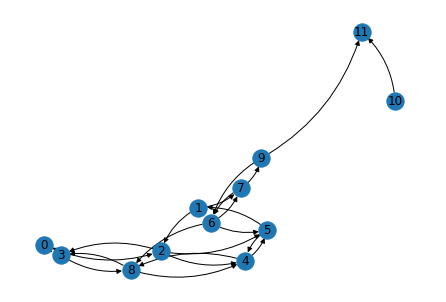

In [11]:
# Copy our graph
G_copy = copy(G)
# Print the initial graph and its edges list
print_graph(G)
print(G)

[(0, 3, 7), (0, 2, 3), (1, 2, 1), (1, 7, 2), (2, 5, 2), (2, 4, 3), (2, 3, 6), (3, 8, 9), (3, 0, 2), (4, 5, 2), (4, 8, 3), (5, 4, 2), (5, 1, 4), (6, 8, 2), (6, 5, 6), (6, 7, 4), (7, 6, 4), (7, 9, 4), (8, 4, 3), (8, 3, 3), (9, 6, 4), (9, 11, 1), (10, 11, 1), (3, 0, 2), (4, 1, 4), (5, 2, 2), (11, 6, 5), (8, 9, 6)]


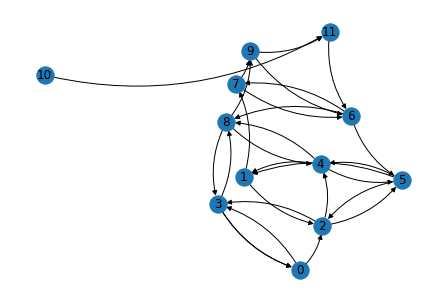

In [12]:
# Convert the graph to eulerian
G_eul = directed_to_eulerian(G_copy)
# Print the new eulerian graph and its edges list
print(G_eul)
print_graph(G_eul)

In [13]:
# Find the eulerian path
eulerian_path = get_eulerian_path(G_eul)
# Print eulerian path
print(eulerian_path)

[10, 11, 6, 7, 9, 6, 5, 2, 3, 0, 2, 4, 1, 7, 6, 8, 3, 0, 3, 8, 4, 5, 1, 2, 5, 4, 8, 9, 11]


In [14]:
# Find the real path
true_path = replace_nodes(G, eulerian_path)
# Print the final real path
print(true_path)

[10, 11, 9, 6, 7, 9, 6, 5, 1, 2, 3, 0, 2, 4, 5, 1, 7, 6, 8, 3, 0, 3, 8, 4, 5, 1, 2, 5, 4, 8, 4, 5, 1, 7, 9, 11]


### Test avec une vraie zone de Monreal

In [15]:
real_G = [(2187161104, 301495983, 42.542), (2187161104, 2187161105, 37.878), (2187161104, 2187161117, 67.978), (2187161104, 2187161118, 101.438), (301495983, 615017544, 66.387), (301495983, 615017546, 73.866), (301495983, 2187162903, 40.899), (2187161105, 2187161113, 34.982), (2187161105, 2187161106, 121.617), (2187161117, 615017544, 40.396), (2187161117, 371474024, 69.239), (2187161118, 2187161106, 44.747), (2187161118, 371474024, 73.995), (2187161118, 615001828, 38.42), (2187161113, 2187161109, 140.759), (2187161113, 615017546, 41.433), (2187161106, 2187161109, 37.106), (2187161109, 615001834, 37.605), (615001834, 615001828, 84.301), (615001834, 615001836, 122.592), (615017546, 2187162922, 40.279), (615017544, 615017532, 74.543), (615017544, 2187162910, 40.654), (371474024, 615001826, 38.812), (615001828, 615001826, 77.42), (615001828, 615001830, 15.593), (615017532, 248511702, 71.909), (615017532, 2188531350, 72.924), (615017532, 2187162915, 41.737), (248511702, 2188531370, 32.518), (248511702, 2187162887, 41.736), (2188531350, 2188531370, 85.13), (2188531350, 615001807, 39.419), (2187162915, 2187162880, 41.084), (2187162915, 2187162900, 247.958), (2187162915, 2187162918, 36.514), (615017534, 2188531388, 35.57), (615017534, 2189049774, 34.301), (615017534, 615017535, 77.436), (2188531388, 2188531373, 38.236), (2188531388, 2188531381, 38.503), (2188531388, 2188531396, 119.103), (2189049774, 2189049736, 113.266), (2189049774, 2189049737, 37.578), (615017535, 2189049755, 34.145), (615017535, 2188531375, 37.001), (615017535, 615017537, 71.644), (2189049755, 2189049737, 40.629), (2189049755, 2189049740, 5.584), (2188531375, 2187162920, 4.948), (2188531375, 2188531381, 38.693), (615017537, 2187162900, 42.729), (615017537, 2189049760, 39.307), (615017537, 615017543, 70.628), (2187162900, 2187162890, 37.378), (2187162900, 2187162898, 38.86), (2189049760, 2189049759, 248.819), (2189049760, 2189049777, 36.955), (2189049760, 2189049765, 36.575), (615017543, 615017538, 67.255), (615017543, 2189049757, 38.899), (615017543, 2187162905, 43.081), (615017538, 2187162893, 39.867), (615017538, 2189049739, 41.996), (2187162893, 2187162903, 247.85699999999997), (2187162893, 2187162912, 35.006), (2189049739, 2189049754, 34.856), (2189049757, 2189049754, 32.723), (2189049757, 2189049763, 249.076), (2189049757, 2189049765, 33.25), (2187162905, 2187162898, 31.656), (2187162905, 2187162912, 32.537), (2187162905, 2187162910, 248.53), (2187162910, 2187162880, 32.431), (2187162910, 2187162885, 33.797), (2187162922, 2187162903, 74.343), (615017584, 2189049736, 180.975), (615017584, 615017585, 84.696), (2140361825, 615001811, 228.54), (2140361825, 615001830, 10.936), (615001811, 9256960176, 7.414), (615001811, 615001817, 15.746), (615001826, 615001807, 79.669), (2189049736, 2189049764, 39.572), (615017585, 615017586, 70.446), (615017585, 2189049771, 40.821), (615017586, 615017587, 64.125), (615017586, 2189049759, 40.295), (2189049771, 2189049732, 35.021), (2189049771, 2189049764, 181.114), (2189049771, 2189049768, 136.215), (615017587, 2189049763, 40.334), (2189049759, 2189049732, 35.578), (2189049759, 2189049742, 34.047), (2189049763, 2189049742, 30.881), (2189049763, 2189049761, 35.082), (2188531370, 9306783005, 4.733), (2188531370, 615001817, 41.681000000000004), (615001807, 615001817, 83.134), (2188531362, 2187162887, 127.62), (2188531362, 2187162920, 121.265), (2188531362, 2188531384, 37.449), (2187162887, 2187162918, 35.579), (2187162887, 9306783005, 76.72800000000001), (2187162920, 2187162890, 34.32), (2188531384, 2188531381, 126.342), (2188531384, 2188531392, 184.89), (2188531384, 2188531394, 38.902), (2188531373, 2188531386, 118.978), (9306783005, 9256960177, 41.67200000000001), (9306783005, 2188531392, 33.845), (615001817, 9256960177, 7.531), (2188531386, 2188531396, 38.422), (9256960176, 9256960177, 15.667), (9256960177, 615001803, 75.58300000000001), (615001803, 1764326134, 41.367000000000004), (2187162903, 2187162885, 33.131), (1764326134, 2188531392, 43.505), (1764326134, 2188531394, 166.316), (2188531394, 2188531396, 7.358), (615001836, 615001851, 75.47500000000001), (2187162880, 2187162898, 248.257), (2187162885, 2187162912, 248.182), (2187162918, 2187162890, 248.475), (2189049732, 2189049777, 248.402), (2189049777, 2189049740, 34.534), (2189049764, 2189049737, 115.259), (2189049764, 2189049768, 41.31), (2189049754, 2189049761, 249.049), (2189049740, 2189049768, 111.751), (2189049742, 2189049765, 248.955)]

In [16]:
# Import functions to convert the graph
import sys
sys.path.append('./scripts')
import simplify_vertices as sv

In [17]:
# Convert vertices
extracted = sv.extract_vertices(real_G)
new_real_G = sv.replace_vertices(real_G, extracted)

In [18]:
# Convert graph to eulerian
G_copy = copy(real_G)
G_eul = directed_to_eulerian(G_copy)
print(G_eul)

[(0, 1, 42.542), (0, 2, 37.878), (0, 3, 67.978), (0, 4, 101.438), (1, 5, 66.387), (1, 6, 73.866), (1, 7, 40.899), (2, 8, 34.982), (2, 9, 121.617), (3, 5, 40.396), (3, 10, 69.239), (4, 9, 44.747), (4, 10, 73.995), (4, 11, 38.42), (8, 12, 140.759), (8, 6, 41.433), (9, 12, 37.106), (12, 13, 37.605), (13, 11, 84.301), (13, 14, 122.592), (6, 15, 40.279), (5, 16, 74.543), (5, 17, 40.654), (10, 18, 38.812), (11, 18, 77.42), (11, 19, 15.593), (16, 20, 71.909), (16, 21, 72.924), (16, 22, 41.737), (20, 23, 32.518), (20, 24, 41.736), (21, 23, 85.13), (21, 25, 39.419), (22, 26, 41.084), (22, 27, 247.958), (22, 28, 36.514), (29, 30, 35.57), (29, 31, 34.301), (29, 32, 77.436), (30, 33, 38.236), (30, 34, 38.503), (30, 35, 119.103), (31, 36, 113.266), (31, 37, 37.578), (32, 38, 34.145), (32, 39, 37.001), (32, 40, 71.644), (38, 37, 40.629), (38, 41, 5.584), (39, 42, 4.948), (39, 34, 38.693), (40, 27, 42.729), (40, 43, 39.307), (40, 44, 70.628), (27, 45, 37.378), (27, 46, 38.86), (43, 47, 248.819), (43,

In [19]:
# Find the eulerian path
eulerian_path = get_eulerian_path(G_eul)
print(eulerian_path)
print(len(eulerian_path))

[75, 77, 59, 60, 67, 70, 61, 19, 44, 52, 17, 58, 44, 51, 49, 74, 75, 76, 74, 42, 32, 40, 44, 50, 54, 56, 43, 49, 66, 47, 71, 52, 55, 75, 34, 51, 57, 72, 67, 65, 70, 16, 22, 28, 29, 32, 39, 34, 13, 14, 82, 40, 43, 48, 40, 27, 46, 74, 24, 73, 76, 30, 35, 52, 46, 60, 66, 68, 57, 71, 49, 62, 64, 59, 36, 29, 31, 37, 61, 62, 63, 79, 32, 38, 37, 31, 36, 65, 37, 38, 41, 30, 34, 8, 6, 0, 4, 11, 19, 3, 10, 0, 3, 5, 17, 26, 22, 27, 45, 67, 69, 51, 56, 72, 22, 26, 46, 53, 55, 0, 2, 9, 0, 1, 7, 43, 47, 69, 48, 41, 70, 4, 10, 18, 4, 9, 12, 1, 6, 15, 7, 2, 8, 12, 13, 11, 18, 25, 16, 21, 25, 64, 1, 5, 16, 20, 24, 28, 45, 39, 42, 45, 50, 53, 7, 58, 55, 81, 77, 35, 21, 23, 64, 79, 80, 81, 76, 29, 30, 33, 78, 35, 20, 23, 73, 79]
186


In [20]:
# Find the real path
true_path = replace_nodes(G_copy, eulerian_path)
# Print the final real path
def replace_vertices_back_in_path(path, l):
    for i in range(len(path)):
        path[i] = l[path[i]]
    return path
# J'ai directemenet copie la fct psk ca marchait pas le import
replace_vertices_back_in_path(true_path, extracted)
#print(replace_vertices_back_in_path(true_path, extracted))
print(true_path)
print(len(true_path))
print(len(G_copy))
print(G_copy)

def check_if_ok(G, path):
    for i in range(len(path) - 1):
        first = path[i]
        second = path[i + 1]
        flag = True
        for (a, b, w) in G:
            if (a == first and b == second) or (a == second and b == first):
                flag = False
                break
        if (flag):
            print("debug ", first, second)
            return False
    return True


[2188531384, 2188531394, 2188531396, 2188531388, 615017534, 2189049774, 2189049736, 615017584, 615017585, 2189049771, 2189049768, 2189049740, 2189049755, 615017535, 2188531375, 2187162920, 2188531362, 2187162887, 248511702, 2188531370, 615001817, 615001811, 2140361825, 615001830, 615001828, 2187161118, 371474024, 2187161117, 615017544, 2187162910, 2187162905, 615017543, 2187162905, 2187162910, 2187162885, 2187162912, 2187162905, 615017543, 2189049757, 2189049765, 2189049760, 615017537, 615017535, 2188531375, 2187162920, 2188531362, 2188531384, 2188531392, 2188531384, 2188531362, 2187162920, 2188531375, 615017535, 615017537, 615017543, 615017538, 2189049739, 2189049754, 2189049757, 2189049765, 2189049760, 2189049765, 2189049742, 2189049759, 615017586, 2189049759, 2189049742, 2189049763, 2189049757, 615017543, 2187162905, 2187162912, 2187162905, 2187162898, 2187162900, 2187162890, 2187162920, 2188531362, 2188531384, 2188531381, 2188531375, 615017535, 615017537, 2189049760, 2189049765, 21